In [1]:
#Check pep8 format
#!pip install pycodestyle
#!pip install --index-url https://test.pypi.org/simple/ nbpep8


In [2]:
#from nbpep8.nbpep8 import pep8
from ast import literal_eval
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer

In [3]:
#display options
pd.set_option('display.max_colwidth', None)

# NBME - Score Clinical Patient Notes : analysis

In [4]:
path_patient_note = ("../input/nbme-score-clinical-patient-notes/"
                     "patient_notes.csv")
patient_notes = pd.read_csv(path_patient_note)
#pep8(_ih)

In [5]:
patient_notes.head(3)

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began 2-3 months ago,sudden,intermittent for 2 days(lasting 3-4 min),worsening,non-allev/aggrav\r\n-associated with dispnea on exersion and rest,stressed out about school\r\n-reports fe feels like his heart is jumping out of his chest\r\n-ros:denies chest pain,dyaphoresis,wt loss,chills,fever,nausea,vomiting,pedal edeam\r\n-pmh:non,meds :aderol (from a friend),nkda\r\n-fh:father had MI recently,mother has thyroid dz\r\n-sh:non-smoker,mariguana 5-6 months ago,3 beers on the weekend, basketball at school\r\n-sh:no std"
1,1,0,"17 yo male with recurrent palpitations for the past 3 mo lasting about 3 - 4 min, it happened about 5 - 6 times since the beginning. One time durign a baskeball game two days ago light headedness, pressure in the chest, catching breath, but no fainting. During teh episodes no sweating. No diarrhea, no heat intolerance, no weight loss. Has tried aterol to be able to better concentrate, has received it from his roommate. ."
2,2,0,"Dillon Cleveland is a 17 y.o. male patient with no significant PMH who presents with complaints of heart pounding. This has been going on for a few months and happens once or twice a month. He cannot think of any triggers, and it has occurred both with activity and at rest. Occasionally, it is accompanied by chest pressure but not pain that is located at the center of his chest. On one instance, he experienced chest pressure, lightheadedness and shortness of breath for 10 minutes with the heart pounding. \r\n\r\nOtherwise, he has not had shortness of breath, chest pain, anxiety, \r\n\r\nMedication: adderall twice a week as study aid (not prescribed)\r\nFH: mother - thyroid disease, father - heart attack at age 52, both living\r\nSH: no smoking; 3-4 drinks on the weekend per sitting; marijuanna once recently, no other recreational drugs"


In [6]:
patient_notes.iloc[5000:5003, :]

,pn_num,case_num,pn_history
5000,22107,2,"44 yo F c/o irregular periods for 3 years\r\nLMP : 2 month ago, cyces every 3 week t o every 4 months, lasting about 2-6 days, flow ranging from light to heavy, with abdominal discomfort, breast tenderness 2 days before last menstrual period. no dyspareunia, no postcoidal bleeding, no vaginal bleeding, no vaginal discharge. no change in weight appetite. With occ hot flashes, vaginal drying and pruritus, sweating, palpitations. . no change in voice, no breast dischargfge, no visional changes. \r\nmed: HCTZ. NKDA. pmh: HTN 6 Y. Menarche: 14 . G2P2, uncomplicated vaginal birth.\r\nno smoking, occ ETOH, no rec drugs, no STD, sexually active with husband\r\n"
5001,22108,2,"This is a 44 year old G2P2 female presenting with a 3 year history of irregular periods. She notes that her periods have been unpredictable, and estimates she has been haivng 5-6 periods per year. The flow varies in heaviness. She also notes an episode 1 week ago of waking up drenched in sweat. She notes hot flashes and sweating in the daytime as well. She has had vaginal dryness during sex for the past year. She denies cramping, changes in weight, changes in hair/skin/nails, concentration or mood, or hot or cold intolerance. \r\nPMHx: HTN\r\nMedications: HCTZ\r\nSurgeries: None\r\nFamily history: noncontributory\r\nOb/gyn: 2 children, vaginal deliveries without complications. Pap smear 1 year ago was normal. Copper IUD was placed 4 years ago. Sexually active with husband.\r\nSocial: Non-smoker, drinks rarely, no drug use."
5002,22109,2,"44 yo f G2P2A0, complains of irregular periods for the past 3 years. her periods can appear between 3 weeks to 4 months, varies between 5-6 pads on heavy days to 2-3 pads on low days and can last 2-6 days. she further mentions hot flushes and vaginal dryness. denies menustral periods or abdominal periods. denies spotting between periods. unknown fibroid or any gynecological abnormality. PAP smear - a year ago and normal.mentions early morning awakening, denies mood change. she did not see an OBGYN for the past 3 years. she denies changes in bowel, GI, or urinary symptoms, and no change in weight or appetite. \r\nROS: None except above mentioned\r\nMEDS:HCTZ\r\nALLERGY: none\r\nPMH: HTN\r\nPSH: none\r\nSH: officer manager at an isurance company, rarely drinks, denies tobacco or drug use, sexually active with husband\r\nFH: non contributory, does not remember when her mother got menopausal."


In [7]:
path_features = ("../input/nbme-score-clinical-patient-notes/"
                "/features.csv")
features = pd.read_csv(path_features)

In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   feature_num   143 non-null    int64 
 1   case_num      143 non-null    int64 
 2   feature_text  143 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [9]:
features.head()

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myocardial-infarction
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [10]:
features[features['case_num'] == 5]
#pep8(_ih)

,feature_num,case_num,feature_text
69,500,5,Onset-5-years-ago
70,501,5,Female
71,502,5,No-caffeine-use
72,503,5,Associated-SOB-OR-Associated-shortness-of-breath
73,504,5,Episodes-of-heart-racing
74,505,5,Recent-visit-to-emergency-department-with-negative-workup
75,506,5,No-chest-pain
76,507,5,No-illicit-drug-use
77,508,5,Associated-nausea
78,509,5,Increased-frequency-recently


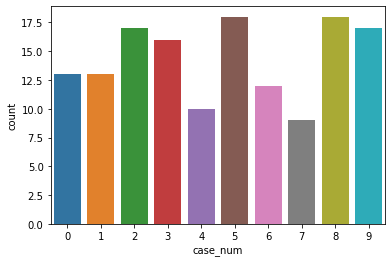

In [11]:
sns.countplot(data=features, x='case_num')
plt.show()

In [12]:
body = '-'.join(features['feature_text'].apply(lambda x: x.lower()).tolist())

(-0.5, 2999.5, 1999.5, -0.5)

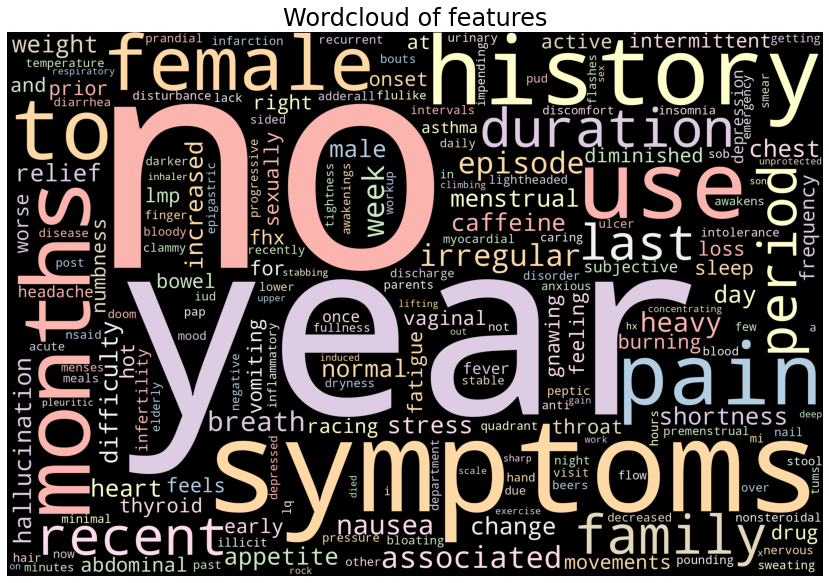

In [13]:
# Import package
from wordcloud import WordCloud, STOPWORDS

# Generate word cloud
wordcloud = WordCloud(width=3000,
                      height=2000,
                      random_state=1, 
                      background_color='black',
                      colormap='Pastel1',
                      collocations=False,
                      stopwords=['-', 'or', 'of', 'with', 'ago'])\
                      .generate(body)
# Plot
plt.rcParams["figure.figsize"] = (15, 10)
plt.imshow(wordcloud)
plt.title('Wordcloud of features', fontsize=24)
plt.axis('off')
#pep8(_ih)

# NBME - Score Clinical Patient Notes : modeling
- **Framework:** Pytorch
- **Model Architecture:**
    - BERT
    - Linear(768, 512)
    - Linear(512, 1)
- **LR:** 1e-5
- **Batch Size:** 8
- **Epoch:** 6
- **Dropout:** 0.2
- **Criterion:** BCEWithLogitsLoss
- **Optimizer:** AdamW

# Tokenizer params
- **Max Lenght:** 416
- **Padding:** max_lenght
- **Truncation:** only_scond


# Helper Functions
### 1. Datasets Helper Function
need to merge `features.csv`, `patient_notes.csv` with `train.csv`

In [14]:
BASE_URL = "../input/nbme-score-clinical-patient-notes"


def process_feature_text(text):
    return text.replace("-OR-", ";-").replace("-", " ")


def prepare_datasets():
    features = pd.read_csv(f"{BASE_URL}/features.csv")
    notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv")
    df = pd.read_csv(f"{BASE_URL}/train.csv")
    df["annotation_list"] = [literal_eval(x) for x in df["annotation"]]
    df["location_list"] = [literal_eval(x) for x in df["location"]]

    merged = df.merge(notes, how="left")
    merged = merged.merge(features, how="left")

    merged["feature_text"] = [process_feature_text(x) for x in
                              merged["feature_text"]]
    merged["feature_text"] = merged["feature_text"].apply(lambda x: x.lower())
    merged["pn_history"] = merged["pn_history"].apply(lambda x: x.lower())

    return merged


#pep8(_ih)

### 2. Tokenizer Helper Function

In [15]:
def loc_list_to_ints(loc_list):
    to_return = []
    for loc_str in loc_list:
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            start, end = loc.split()
            to_return.append((int(start), int(end)))
    return to_return


def tokenize_and_add_labels(tokenizer, data, config):
    out = tokenizer(
        data["feature_text"],
        data["pn_history"],
        truncation=config['truncation'],
        max_length=config['max_length'],
        padding=config['padding'],
        return_offsets_mapping=config['return_offsets_mapping']
    )
    labels = [0.0] * len(out["input_ids"])
    out["location_int"] = loc_list_to_ints(data["location_list"])
    out["sequence_ids"] = out.sequence_ids()

    for idx, (seq_id, offsets) in enumerate(zip(out["sequence_ids"],
                                                out["offset_mapping"])):
        if not seq_id or seq_id == 0:
            labels[idx] = -1
            continue

        token_start, token_end = offsets
        for feature_start, feature_end in out["location_int"]:
            if token_start >= feature_start and token_end <= feature_end:
                labels[idx] = 1.0
                break

    out["labels"] = labels

    return out


#pep8(_ih)

### 3. Prediction and Score Helper Function

In [16]:
def get_location_predictions(preds, offset_mapping, sequence_ids, test=False):
    all_predictions = []
    for pred, offsets, seq_ids in zip(preds, offset_mapping, sequence_ids):
        pred = 1 / (1 + np.exp(-pred))
        start_idx = None
        end_idx = None
        current_preds = []
        for pred, offset, seq_id in zip(pred, offsets, seq_ids):
            if seq_id is None or seq_id == 0:
                continue

            if pred > 0.5:
                if start_idx is None:
                    start_idx = offset[0]
                end_idx = offset[1]
            elif start_idx is not None:
                if test:
                    current_preds.append(f"{start_idx} {end_idx}")
                else:
                    current_preds.append((start_idx, end_idx))
                start_idx = None
        if test:
            all_predictions.append("; ".join(current_preds))
        else:
            all_predictions.append(current_preds)
            
    return all_predictions



def calculate_char_cv(predictions, offset_mapping, sequence_ids, labels):
    all_labels = []
    all_preds = []
    for preds, offsets, seq_ids, labels in zip(predictions, offset_mapping,
                                               sequence_ids, labels):

        num_chars = max(list(chain(*offsets)))
        char_labels = np.zeros(num_chars)

        for o, s_id, label in zip(offsets, seq_ids, labels):
            if s_id is None or s_id == 0:
                continue
            if int(label) == 1:
                char_labels[o[0]:o[1]] = 1

        char_preds = np.zeros(num_chars)

        for start_idx, end_idx in preds:
            char_preds[start_idx:end_idx] = 1
            
        all_labels.extend(char_labels)
        all_preds.extend(char_preds)

    results = precision_recall_fscore_support(all_labels,
                                              all_preds,
                                              average="binary",
                                              labels=np.unique(all_preds))
    accuracy = accuracy_score(all_labels, all_preds)
    

    return {
        "Accuracy": accuracy,
        "precision": results[0],
        "recall": results[1],
        "f1": results[2]
    }


#pep8(_ih)

# Dataset

In [17]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        tokens = tokenize_and_add_labels(self.tokenizer, data, self.config)

        input_ids = np.array(tokens["input_ids"])
        attention_mask = np.array(tokens["attention_mask"])
        token_type_ids = np.array(tokens["token_type_ids"])

        labels = np.array(tokens["labels"])
        offset_mapping = np.array(tokens['offset_mapping'])
        sequence_ids = np.array(tokens['sequence_ids']).astype("float16")
        
        return input_ids, attention_mask, token_type_ids, labels, offset_mapping, sequence_ids

# Model
- Lets use **Pub med BERT** base Architecture downloaded at https://www.kaggle.com/jpmiller/layoutlm
- Also Used 2 FC layers


In [18]:
import torch.nn.functional as F


class CustomModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = AutoModel.from_pretrained(config['model_name']) 
        self.dropout = nn.Dropout(p=config['dropout'])
        self.config = config
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 1)
        

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        logits = F.relu(self.fc1(outputs[0]))
        logits = self.fc2(self.dropout(logits)).squeeze(-1)
        return logits
    
    
#pep8(_ih)

## Hyperparameters


In [19]:
hyperparameters = {
    "max_length": 416,
    "padding": "max_length",
    "return_offsets_mapping": True,
    "truncation": "only_second",
    "model_name": ("../input/layoutlm/BiomedNLP-PubMedBERT"
                   "-base-uncased-abstract-fulltext"),
    "dropout": 0.2,
    "lr": 1e-5,
    "test_size": 0.2,
    "seed": 1268,
    "batch_size": 8
}
#pep8(_ih)

# Prepare Datasets
Train and Test split: 20%

Total Data:
- Train: 11440
- Test: 2860

In [20]:
train_df = prepare_datasets()

X_train, X_test = train_test_split(train_df,
                                   test_size=hyperparameters['test_size'],
                                   random_state=hyperparameters['seed'])


print("Train size", len(X_train))
print("Test Size", len(X_test))
#pep8(_ih)

Train size 11440
Test Size 2860


In [21]:
#X_test[['id', 'case_num', 'pn_num', 'feature_num']]

In [22]:
#X_test[['id', 'case_num', 'pn_num', 'feature_num']].to_csv('test.csv')

In [23]:
tokenizer = AutoTokenizer.from_pretrained(hyperparameters['model_name'])

training_data = CustomDataset(X_train,
                              tokenizer,
                              hyperparameters)

train_dataloader = DataLoader(training_data,
                              batch_size=hyperparameters['batch_size'],
                              shuffle=True)

test_data = CustomDataset(X_test, tokenizer, hyperparameters)

test_dataloader = DataLoader(test_data,
                             batch_size=hyperparameters['batch_size'],
                             shuffle=False)

# Train
Lets train the model
with BCEWithLogitsLoss and AdamW as optimizer

**Notes:** on BCEWithLogitsLoss, the default value for reduction is `mean` (the sum of the output will be divided by the number of elements in the output). If we use this default value, it will produce negative loss. Because we have some negative labels. To fix this negative loss issue, we can use `none` as parameter. To calculate the mean, first, we have to filter out the negative values. [DOC](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)

In [24]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = CustomModel(hyperparameters).to(DEVICE)

criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
optimizer = optim.AdamW(model.parameters(), lr=hyperparameters['lr'])
#pep8(_ih)

In [25]:
def train_model(model, dataloader, optimizer, criterion):
        model.train()
        train_loss = []

        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            token_type_ids = batch[2].to(DEVICE)
            labels = batch[3].to(DEVICE)

            logits = model(input_ids,
                           attention_mask,
                           token_type_ids)
            loss = criterion(logits, labels)
            # since, we have
            loss = torch.masked_select(loss, labels > -1.0).mean()
            train_loss.append(loss.item() * input_ids.size(0))
            loss.backward()
            # clip the the gradients to 1.0.
            #It helps in preventing the exploding gradient problem
            # it's also improve f1 accuracy slightly
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        return sum(train_loss)/len(train_loss)

    
#pep8(_ih)

In [26]:
def eval_model(model, dataloader, criterion):
        model.eval()
        valid_loss = []
        preds = []
        offsets = []
        seq_ids = []
        valid_labels = []

        for batch in tqdm(dataloader):
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
            token_type_ids = batch[2].to(DEVICE)
            labels = batch[3].to(DEVICE)
            offset_mapping = batch[4]
            sequence_ids = batch[5]

            logits = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(logits, labels)
            loss = torch.masked_select(loss, labels > -1.0).mean()
            valid_loss.append(loss.item() * input_ids.size(0))

            preds.append(logits.detach().cpu().numpy())
            offsets.append(offset_mapping.numpy())
            seq_ids.append(sequence_ids.numpy())
            valid_labels.append(labels.detach().cpu().numpy())

        preds = np.concatenate(preds, axis=0)
        offsets = np.concatenate(offsets, axis=0)
        seq_ids = np.concatenate(seq_ids, axis=0)
        valid_labels = np.concatenate(valid_labels, axis=0)
        location_preds = get_location_predictions(preds,
                                                  offsets,
                                                  seq_ids,
                                                  test=False)
        score = calculate_char_cv(location_preds,
                                  offsets,
                                  seq_ids,
                                  valid_labels)

        return sum(valid_loss)/len(valid_loss), score


#pep8(_ih)

In [27]:
import time

train_loss_data, valid_loss_data = [], []
score_data_list = []
valid_loss_min = np.Inf
since = time.time()
epochs = 30

In [28]:
best_loss = np.inf

for i in range(epochs):
    print("Epoch: {}/{}".format(i + 1, epochs))
    # first train model
    train_loss = train_model(model, train_dataloader, optimizer, criterion)
    train_loss_data.append(train_loss)
    print(f"Train loss: {train_loss}")
    # evaluate model
    valid_loss, score = eval_model(model, test_dataloader, criterion)
    valid_loss_data.append(valid_loss)
    score_data_list.append(score)
    print(f"Valid loss: {valid_loss}")
    print(f"Valid score: {score}")
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "nbme_pubmed_bert.pth")

    
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.40853985249991576


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.15215200269021079
Valid score: {'Accuracy': 0.9915955141874595, 'precision': 0.6729749137152256, 'recall': 0.8398277157888652, 'f1': 0.7471998971259565}
Epoch: 2/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.12598221657751724


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.12348424013719535
Valid score: {'Accuracy': 0.9932068121694253, 'precision': 0.7268801552644347, 'recall': 0.8661039486616177, 'f1': 0.7904081040441079}
Epoch: 3/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.09067626950326448


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.11218218090558861
Valid score: {'Accuracy': 0.9936984525725191, 'precision': 0.7443388795904302, 'recall': 0.874168931028502, 'f1': 0.8040466884687991}
Epoch: 4/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.07049830527193


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.11305034533061646
Valid score: {'Accuracy': 0.9941794051407631, 'precision': 0.7807156046779243, 'recall': 0.8432965254090304, 'f1': 0.8108002946040216}
Epoch: 5/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.05648647709158091


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.10682794197298148
Valid score: {'Accuracy': 0.9938933986801807, 'precision': 0.7527251007913991, 'recall': 0.8743134647626756, 'f1': 0.8089761420776719}
Epoch: 6/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.046130512836861495


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.13145122636558867
Valid score: {'Accuracy': 0.9933461815358675, 'precision': 0.7197561088271975, 'recall': 0.9008498583569405, 'f1': 0.8001848713603451}
Epoch: 7/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.038281071171761424


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.12252238873332809
Valid score: {'Accuracy': 0.9939951468679513, 'precision': 0.7629369913497467, 'recall': 0.8617390298895762, 'f1': 0.8093337677146115}
Epoch: 8/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.03229485976337411


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.12125118661840269
Valid score: {'Accuracy': 0.9942183088596166, 'precision': 0.7730547923902338, 'recall': 0.8621726310920969, 'f1': 0.8151853066579207}
Epoch: 9/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.02716338250412879


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.13415658419972834
Valid score: {'Accuracy': 0.9942110411319187, 'precision': 0.7692543803555442, 'recall': 0.8693415043071053, 'f1': 0.8162412300343335}
Epoch: 10/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.026979782957500097


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.14993641512440112
Valid score: {'Accuracy': 0.9942131786988886, 'precision': 0.7702654140356281, 'recall': 0.8674336590160143, 'f1': 0.815966934957581}
Epoch: 11/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.020475264454773604


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.15876732352240894
Valid score: {'Accuracy': 0.9942460972302263, 'precision': 0.769242528472063, 'recall': 0.8727525004336012, 'f1': 0.8177349240957166}
Epoch: 12/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.01788505987847214


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.1477002606536008
Valid score: {'Accuracy': 0.9942576400918641, 'precision': 0.7720331139448786, 'recall': 0.8680407006995433, 'f1': 0.8172268335828003}
Epoch: 13/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.016577662495966983


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.15847810380034827
Valid score: {'Accuracy': 0.9942867110026558, 'precision': 0.7760871826883062, 'recall': 0.8625484188009481, 'f1': 0.8170367733632705}
Epoch: 14/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.013954968609746054


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.16795698075564203
Valid score: {'Accuracy': 0.9943982919984883, 'precision': 0.7840695799296798, 'recall': 0.8573452043707002, 'f1': 0.819071816185913}
Epoch: 15/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.012803154809283221


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.16711994028430427
Valid score: {'Accuracy': 0.9942042009176147, 'precision': 0.7754038698190768, 'recall': 0.8560733075099728, 'f1': 0.8137442125654307}
Epoch: 16/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.016859098763695575


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.16289981738668893
Valid score: {'Accuracy': 0.994337585096541, 'precision': 0.7735578278362932, 'recall': 0.8725501532057582, 'f1': 0.8200774298716295}
Epoch: 17/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.01046146952598876


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.18990270528416997
Valid score: {'Accuracy': 0.9942452422034382, 'precision': 0.7680016232531006, 'recall': 0.8752962941550558, 'f1': 0.8181462017535563}
Epoch: 18/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.00982154208599106


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.20209781756459536
Valid score: {'Accuracy': 0.9941721374130652, 'precision': 0.7617370892018779, 'recall': 0.8817424986991964, 'f1': 0.8173584501192421}
Epoch: 19/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.011549068618440326


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.17529622352407875
Valid score: {'Accuracy': 0.9945513417935384, 'precision': 0.7888016496153542, 'recall': 0.8625195120541135, 'f1': 0.8240151337319286}
Epoch: 20/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.00831415429151792


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.19779714560559272
Valid score: {'Accuracy': 0.9944671216549215, 'precision': 0.7900391148261265, 'recall': 0.8524310574087992, 'f1': 0.8200500556173526}
Epoch: 21/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.0073491036303562594


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.18970566267122474
Valid score: {'Accuracy': 0.994265335332956, 'precision': 0.7815890236119974, 'recall': 0.8496849164595016, 'f1': 0.8142156726960472}
Epoch: 22/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.008458358215758027


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.196768878473513
Valid score: {'Accuracy': 0.9943243321813272, 'precision': 0.7691802616293753, 'recall': 0.8804416950916344, 'f1': 0.8210588742721587}
Epoch: 23/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.00948243099875757


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.18738737879157263
Valid score: {'Accuracy': 0.9943658009805447, 'precision': 0.7745864854468522, 'recall': 0.8731282881424525, 'f1': 0.8209107339412139}
Epoch: 24/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.006276226140276778


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.18466797478745223
Valid score: {'Accuracy': 0.994348700444785, 'precision': 0.7742423853634754, 'recall': 0.8722032722437417, 'f1': 0.8203085706518046}
Epoch: 25/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.006000240858671712


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.23012335641026369
Valid score: {'Accuracy': 0.9943769163287886, 'precision': 0.776722335510183, 'recall': 0.8698329190032954, 'f1': 0.8206449853412422}
Epoch: 26/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.007210543187758854


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.192547445869705
Valid score: {'Accuracy': 0.9942614877124101, 'precision': 0.7752841130731022, 'recall': 0.8617679366364109, 'f1': 0.8162415978753406}
Epoch: 27/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.005841916294865582


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.21078845142681332
Valid score: {'Accuracy': 0.9942973988375056, 'precision': 0.7674863456746621, 'recall': 0.8814534312308493, 'f1': 0.8205314497140935}
Epoch: 28/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.005894141557442409


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.22214586746055964
Valid score: {'Accuracy': 0.9942939787303536, 'precision': 0.7732451966357159, 'recall': 0.8690235300919235, 'f1': 0.8183414315462822}
Epoch: 29/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.006227028604969592


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.20575344183155056
Valid score: {'Accuracy': 0.9943251872081152, 'precision': 0.7815487824203687, 'recall': 0.8553795455859398, 'f1': 0.8167991608700453}
Epoch: 30/30


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.004706730577481978


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.19506058898167397
Valid score: {'Accuracy': 0.9944760994361953, 'precision': 0.7775813929660084, 'recall': 0.8774932069144938, 'f1': 0.8245216139502669}
Training completed in 312m 50s


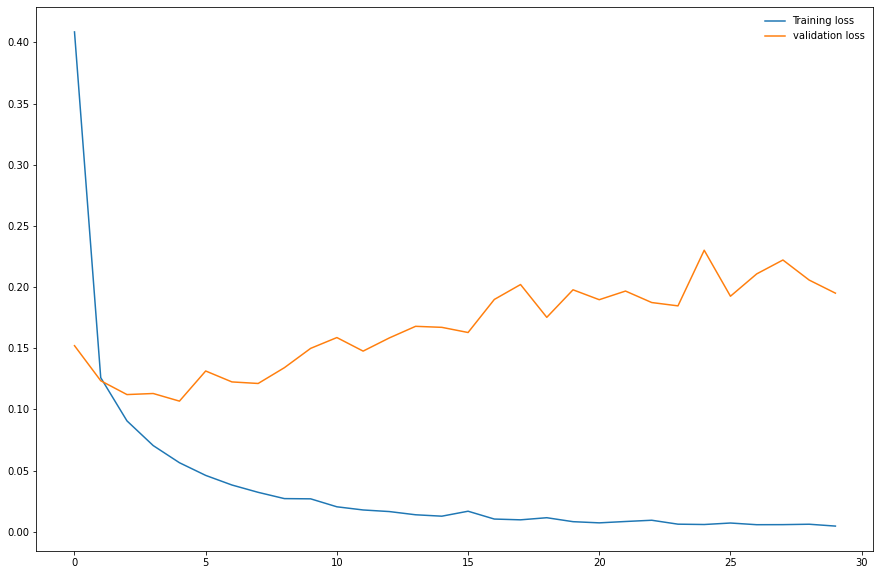

In [29]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [30]:
import pandas as pd

score_df = pd.DataFrame.from_dict(score_data_list)
score_df.head()

,Accuracy,precision,recall,f1
0,0.991596,0.672975,0.839828,0.747200
1,0.993207,0.726880,0.866104,0.790408
2,0.993698,0.744339,0.874169,0.804047
3,0.994179,0.780716,0.843297,0.810800
4,0.993893,0.752725,0.874313,0.808976


# Prepare For Testing

Load best model

In [31]:
model.load_state_dict(torch.load("nbme_pubmed_bert.pth", map_location = DEVICE))

<All keys matched successfully>

In [32]:
def create_test_df():
    feats = pd.read_csv(f"{BASE_URL}/features.csv")
    notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv")
    test = pd.read_csv(f"{BASE_URL}/test.csv")

    merged = test.merge(notes, how="left")
    merged = merged.merge(feats, how="left")

    def process_feature_text(text):
        return text.replace("-OR-", ";-").replace("-", " ")
    
    merged["feature_text"] = [process_feature_text(x) 
                              for x in merged["feature_text"]]
    
    return merged


class SubmissionDataset(Dataset):
    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data.loc[idx]
        tokenized = self.tokenizer(
            example["feature_text"],
            example["pn_history"],
            truncation = self.config['truncation'],
            max_length = self.config['max_length'],
            padding = self.config['padding'],
            return_offsets_mapping = self.config['return_offsets_mapping']
        )
        tokenized["sequence_ids"] = tokenized.sequence_ids()

        input_ids = np.array(tokenized["input_ids"])
        attention_mask = np.array(tokenized["attention_mask"])
        token_type_ids = np.array(tokenized["token_type_ids"])
        offset_mapping = np.array(tokenized["offset_mapping"])
        sequence_ids = np.array(tokenized["sequence_ids"])\
                        .astype("float16")

        return input_ids, attention_mask, token_type_ids, offset_mapping, sequence_ids


test_df = create_test_df()

submission_data = SubmissionDataset(test_df, tokenizer, hyperparameters)
submission_dataloader = DataLoader(submission_data,
                                   batch_size=hyperparameters['batch_size'],
                                   shuffle=False)

#pep8(_ih)

In [33]:
model.eval()
preds = []
offsets = []
seq_ids = []

for batch in tqdm(submission_dataloader):
    input_ids = batch[0].to(DEVICE)
    attention_mask = batch[1].to(DEVICE)
    token_type_ids = batch[2].to(DEVICE)
    offset_mapping = batch[3]
    sequence_ids = batch[4]

    logits = model(input_ids, attention_mask, token_type_ids)
    
    preds.append(logits.detach().cpu().numpy())
    offsets.append(offset_mapping.numpy())
    seq_ids.append(sequence_ids.numpy())

preds = np.concatenate(preds, axis=0)
offsets = np.concatenate(offsets, axis=0)
seq_ids = np.concatenate(seq_ids, axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
location_preds = get_location_predictions(preds, offsets, seq_ids, test=True)

In [35]:
len(location_preds), len(test_df)

(5, 5)

In [36]:
test_df["location"] = location_preds

In [37]:
test_df[["id", "location"]].to_csv("submission.csv", index = False)
pd.read_csv("submission.csv").head()

,id,location
0,00016_000,696 724
1,00016_001,668 693
2,00016_002,203 217
3,00016_003,70 91; 176 183
4,00016_004,222 258; 0 0; 0 0
